# Example of application of Bootstrap

#### Cesar Fernandez-Ramirez for the Joint Physics Analysis Center


This is a bootstrap example for the Joint Physics Analysis Center review <a href="https://arxiv.org/abs/2112.13436">"Novel Approaches in Hadron spectrocopy arXiv:2112.13436"</a> based on a fit to the LHCb data for the $P_c(4312)$ region from <a href="https://doi.org/10.1103/PhysRevLett.122.222001">"Phys.Rev.Lett. 122 (2019) 22, 222001"</a>. This example does not take into account the convolution of the model with the experimental resolution, which is a must to analyze the data and was done in <a href="https://doi.org/10.1103/PhysRevLett.123.092001">"Phys. Rev. Lett. 123 (2019) 092001"</a>. The reason for such simplification is that the convolution with resolution is computationally very demanding.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares

jpac_blue   = "#1F77B4"; jpac_red    = "#D61D28";
jpac_green  = "#2CA02C"; jpac_orange = "#FF7F0E";
jpac_purple = "#9467BD"; jpac_brown  = "#8C564B";
jpac_pink   = "#E377C2"; jpac_gold   = "#BCBD22";
jpac_aqua   = "#17BECF"; jpac_grey   = "#7F7F7F";

jpac_color = [jpac_blue, jpac_red, jpac_green, 
              jpac_orange, jpac_purple, jpac_brown,
              jpac_pink, jpac_gold, jpac_aqua, jpac_grey,'black' ];

dashes = 60*'_';

epsilon = 0.000000001;
gevfm = 5.068; # 1 GeV = 5.068 fm^{-1}
Mlambda0, mK = 5.61960, 0.493677;
Mjpsi, Mproton, MDbar0, MSigmap = 3.0969, 0.9382720813, 1.86483, 2.4529
M11, M12, M21, M22 = Mjpsi, Mproton, MDbar0, MSigmap;
ME1, ME2, ME3, ME4 = Mlambda0, mK, Mjpsi, Mproton
nu1, nu2 = np.sqrt(M11*M12)/(M11+M12), np.sqrt(M21*M22)/(M21+M22);

#   Data treatment
def errores(dw_input,up_input):
    npoints = len(dw_input)
    points  = np.arange(npoints)
    nxypoints = (2,npoints)
    uncertainty = np.zeros(nxypoints)
    for i in points:
        uncertainty[0][i] = dw_input[i]; 
        uncertainty[1][i] = up_input[i];
    return uncertainty

#   Threshold and momenta in the real axis
def sth(M1,M2):
    return  (M1+M2)**2;
def kfh_realaxis(s,M1,M2): 
    return -np.sqrt(sth(M1,M2)-s-epsilon*1j);
def kallen(x,y,z):
    return  x*x + y*y + z*z - 2.*(x*y + x*z + y*z);
def phasespace(s):
    p, q = np.sqrt(kallen(s,ME1**2,ME2**2)), np.sqrt(kallen(s,ME3**2,ME4**2));
    return p*q/(4.*np.sqrt(s))

#   Amplitude
def T11_fh(s,m11,m12,m22):
    t11, t22 = (m11 -  kfh_realaxis(s,M11,M12)),  (m22  - kfh_realaxis(s,M21,M22))
    den = t11*t22 - m12**2;
    return t22/den;

#   Intensity
def Intensity_fh(s,p0,p1,b0,b1,m11,m12,m22):
    P1, B = p0+p1*s, b0 + b1*s;
    T11 = T11_fh(s,m11,m12,m22);
    F2  = np.absolute(P1*T11)**2
    rho = phasespace(s)
    return rho*(F2 + B)

#   MINUIT LSQ function
def LSQint_fh(p0,p1,b0,b1,m11,m12,m22):
    return np.sum(((ydata-Intensity_fh(xdata,p0,p1,b0,b1,m11,m12,m22))**2)/(sigma_ydata**2))

#  Pseudodata generation
def pseudodataset(ydata,y_error):
    pseudodata = [ np.random.normal(ydata[i],y_error[i]) for i in np.arange(y_error.size)]
    return pseudodata

In [2]:
###########################################################
#   Uploading experimental information
###########################################################

file1 = "dataLHCbweight-cut.txt"; lhcbdata = np.loadtxt(file1);
lhcbenergy = lhcbdata[:,0]/1000.; lhcbpoints = lhcbdata[:,1]; y_error = lhcbdata[:,2];
lhcberrors = errores(y_error,y_error);

## Fit with errors from MINUIT

In [3]:
#####################################################
#   MINUIT fit to FH amplitude without convolution
#####################################################

#FH best fit from Pc paper is used as starting input
xdata, ydata, sigma_ydata =np.multiply(lhcbenergy,lhcbenergy), lhcbpoints, lhcberrors[0,:]

b0input, b1input = 402.95, -15.00;
p0input, p1input = 423.16, -23.53;
m11input, m12input, m22input = 2.6, 0.85, 0.22; 

m_fh = Minuit(LSQint_fh, 
                     p0=p0input,p1=p1input,
                     b0=b0input,b1=b1input,
                     m11=m11input,m12=m12input,m22=m22input)
m_fh.errordef = Minuit.LEAST_SQUARES
m_fh.migrad(); m_fh.hesse(); m_fh.minos();
print('chi2=',m_fh.fval); 
print('chi2/dof=',m_fh.fval/(len(ydata)-len(m_fh.values)))
print(dashes)
print(dashes);
print(m_fh.params); print(m_fh.covariance); print(m_fh.covariance.correlation())
print(dashes);

p0fh, p1fh, b0fh, b1fh, m11fh, m12fh, m22fh = m_fh.values

print(m_fh.values)


chi2= 59.176165256635755
chi2/dof= 0.9862694209439292
____________________________________________________________
____________________________________________________________
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   424.3   │    2.5    │    -2.5    │    2.5     │         │         │       │
│ 1 │ p1   │  -23.47   │   0.13    │   -0.13    │    0.13    │         │         │       │
│ 2 │ b0   │    404    │    12     │    -12     │     12     │         │         │       │
│ 3 │ b1   │   -15.0   │    0.6    │    -0.6    │    0.6     │         │         │       │
│ 4 │ m11  │   2.11    │   0.19    │   -0.19    │    0.19    │         │         │       │
│ 5 │ m12  │   1.08    │   0.10    │   -0.10    │    0.10    │         │         │       │
│ 6 │

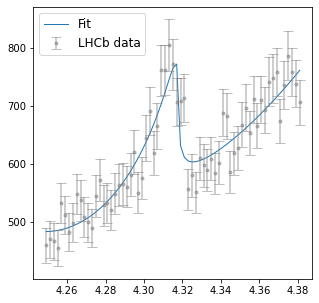

In [6]:
#These are the values obtained from the fit
#p0fh, p1fh = 424.3231930018195, -23.466085713698533 
#b0fh, b1fh =403.7392978177506, -14.966654108537803 
#m11fh, m12fh, m22fh =2.1093761366774757,1.0782175863573542,0.40735660031665855

values = np.array([p0fh, p1fh, b0fh, b1fh, m11fh, m12fh, m22fh])
ss  = np.multiply(lhcbenergy,lhcbenergy);
lineshape_FH = np.array([ Intensity_fh(s,*values) for s in ss ]) 
fig = plt.figure(figsize=(5,5))
plt.errorbar(lhcbenergy, lhcbpoints, yerr=sigma_ydata, fmt="o", markersize=3,capsize=5., c=jpac_color[9], alpha=0.5,zorder=3,label='LHCb data')
plt.plot(lhcbenergy,lineshape_FH,'-',lw=1,c=jpac_color[0], alpha=1,zorder=2,label='Fit')
plt.legend(loc='upper left',ncol=1,frameon=True,fontsize=12)
plt.show()


## Fit with errors from Bootstrap

In [17]:
# Number of BS fits
nbs = 10000; 

In [19]:
p0fhinput, p1fhinput, b0fhinput, b1fhinput = p0fh, p1fh, b0fh, b1fh 
m11fhinput, m12fhinput, m22fhinput = m11fh, m12fh, m22fh

xdata, ydata, sigma_ydata =np.multiply(lhcbenergy,lhcbenergy), lhcbpoints, lhcberrors[0,:]
np.random.seed(1729);
ypseudodata = []
for i in range(nbs): ypseudodata.append(pseudodataset(ydata,y_error))

p0fh_bs, p1fh_bs, b0fh_bs, b1fh_bs = [], [], [], [];
m11fh_bs, m12fh_bs, m22fh_bs = [], [], [];
chisq = [];
for i in range(nbs):
    ydata = ypseudodata[i]
    if np.mod(i+1,np.trunc((nbs)/10))==0:
        print((i+1)*100/nbs,"%")
    m_bs = Minuit(LSQint_fh, 
                         p0=p0fhinput,p1=p1fhinput,
                         b0=b0fhinput,b1=b1fhinput,
                         m11=m11fhinput,m12=m12fhinput,m22=m22fhinput)    
    m_bs.errordef = Minuit.LEAST_SQUARES
    m_bs.migrad()
    c1 = m_bs.fval
    chisq.append(c1)
    p0fh_bs.append(m_bs.values[0]); p1fh_bs.append(m_bs.values[1])
    b0fh_bs.append(m_bs.values[2]); b1fh_bs.append(m_bs.values[3])
    m11fh_bs.append(m_bs.values[4])
    m12fh_bs.append(m_bs.values[5]) 
    m22fh_bs.append(m_bs.values[6])

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %


In [20]:
#Expected values of the parameters and uncertainties
df_parameters = pd.DataFrame({"p0":p0fh_bs,"p1": p1fh_bs,
                              "b0":b0fh_bs,"b1": b1fh_bs,
                              "m11": m11fh_bs, "m12":m12fh_bs, "m22":m22fh_bs});
p0fh_mean, p1fh_mean = np.mean(p0fh_bs), np.mean(p1fh_bs)
b0fh_mean, b1fh_mean = np.mean(b0fh_bs), np.mean(b1fh_bs)
m11fh_mean, m12fh_mean, m22fh_mean = np.mean(m11fh_bs), np.mean(m12fh_bs), np.mean(m22fh_bs)

print(dashes); print('Fit parameters')
print('p0=',p0fh_mean,' -',np.abs(p0fh_mean-np.quantile(p0fh_bs,0.16)),' +',np.abs(np.quantile(p0fh_bs,0.84)-p0fh_mean))
print('p1=',p1fh_mean,' -',np.abs(p1fh_mean-np.quantile(p1fh_bs,0.16)),' +',np.abs(np.quantile(p1fh_bs,0.84)-p1fh_mean))
print('b0=',b0fh_mean,' -',np.abs(b0fh_mean-np.quantile(b0fh_bs,0.16)),' +',np.abs(np.quantile(b0fh_bs,0.84)-b0fh_mean))
print('b1=',b1fh_mean,' -',np.abs(b1fh_mean-np.quantile(b1fh_bs,0.16)),' +',np.abs(np.quantile(b1fh_bs,0.84)-b1fh_mean))
print('m11=',m11fh_mean,' -',np.abs(m11fh_mean-np.quantile(m11fh_bs,0.16)),' +',np.abs(np.quantile(m11fh_bs,0.84)-m11fh_mean))
print('m12=',m12fh_mean,' -',np.abs(m12fh_mean-np.quantile(m12fh_bs,0.16)),' +',np.abs(np.quantile(m12fh_bs,0.84)-m12fh_mean))
print('m22=',m22fh_mean,' -',np.abs(m22fh_mean-np.quantile(m22fh_bs,0.16)),' +',np.abs(np.quantile(m22fh_bs,0.84)-m22fh_mean))

print(dashes); print('covariance matrix')
print(df_parameters.cov()); 
print(dashes); print('correlation matrix')
print(df_parameters.corr())
print(dashes)


____________________________________________________________
Fit parameters
p0= 432.32997907529864  - 78.00769348640921  + 70.40124836839402
p1= -24.30693805967093  - 4.117674630133163  + 4.484197575802458
b0= 1299.1121206884025  - 1383.3364107807438  + 2088.9617692593683
b1= -67.16766314203188  - 117.88919693820635  + 79.3590323916117
m11= 10.237675862339291  - 8.9310154119804  + 6.363126043123021
m12= 2.6482200347120846  - 2.329527615255179  + 1.2725295001485954
m22= 0.7282266723011332  - 0.5245021221183017  + 0.25431074611114896
____________________________________________________________
covariance matrix
               p0           p1            b0             b1           m11  \
p0   33787.757688 -1801.332382 -1.218893e+04     844.174028  -9656.243005   
p1   -1801.332382    96.550641 -3.852718e+02      15.818686    521.908447   
b0  -12188.931188  -385.271839  3.100307e+06 -178090.803766 -17115.403953   
b1     844.174028    15.818686 -1.780908e+05   10244.557661    964.484198  

### Parameter histograms

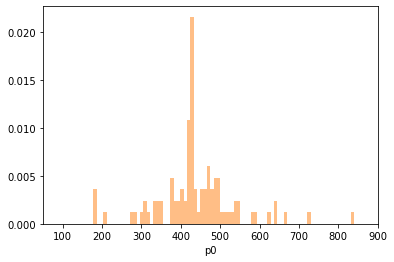

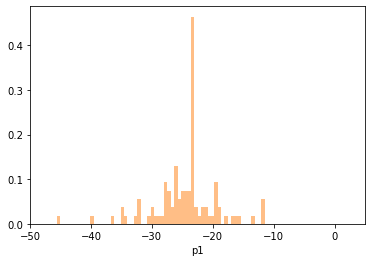

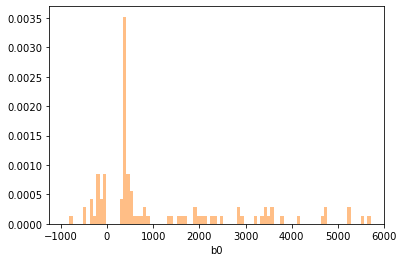

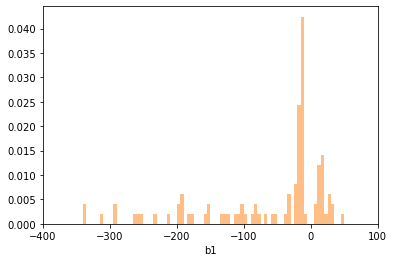

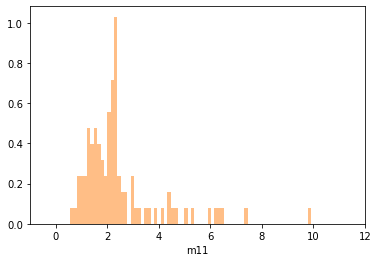

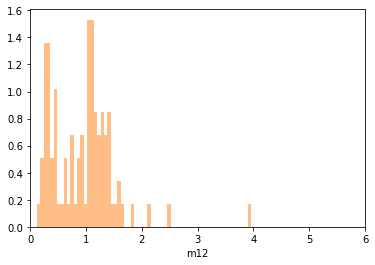

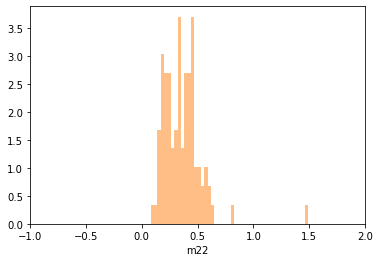

In [21]:
bins1, limits, i = 100, [(50,900),(-50,5),(-1250,6000),(-400,100),(-1,12),(0.,6),(-1,2)], 0;
for name in ["p0","p1","b0","b1","m11","m12","m22"]:
    plt.xlabel(name); plt.xlim(limits[i])
    plt.hist(df_parameters[name], bins=bins1,range=limits[i],density=True,color=jpac_orange,alpha=0.5,label='Bootstrap')
    i+=1; plt.show()
